In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "french_to_english_product.csv"

# Load the latest version
fr_en_kaggle_dataset = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dargolex/french-reviews-on-amazon-items-and-en-translation",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

from pathlib import Path

# Persist a local copy so other notebooks can reuse it
DATA_PATH = Path("../data/raw/french_to_english_product.csv")
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
fr_en_kaggle_dataset.to_csv(DATA_PATH, index=False)
print(f"Saved dataset to: {DATA_PATH.resolve()}")

print("First 5 records:", fr_en_kaggle_dataset.head())

<ipython-input-33-4297385b7aef>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  fr_en_kaggle_dataset = kagglehub.load_dataset(


First 5 records:    rating                                             review  \
0       1  A déconseiller - Article n'a fonctionné qu'une...   
1       1  Si vous voulez être déçu achetez le produit ! ...   
2       1  Écran de mauvaise qualité, car il s'use en peu...   
3       1  Cet engin ne sert à rien les sons sont pourris...   
4       1  Très beau produit mais la grue n'a pas fonctio...   

                                         translation  
0  A discouragement - article Na worked that once...  
1  If you want to be disappointed buy the product...  
2  Screen of poor quality because it suses in a s...  
3  This machine does not serve the sounds are rot...  
4  Very nice product but the crane did not work v...  


Data Preprocessing

1-Reduce the dataset size

In [ ]:
# fr_en_dataset = fr_en_kaggle_dataset.groupby('rating').apply(lambda x: x.sample(n=15000, random_state=42)).reset_index(drop=True)

import pandas as pd
# Sample the data
samples = []
for rating, size in zip([1, 2, 4, 5], [5000, 5000, 5000, 5000]):
    samples.append(fr_en_kaggle_dataset[fr_en_kaggle_dataset['rating'] == rating].sample(n=size, random_state=42))
samples.append(fr_en_kaggle_dataset[fr_en_kaggle_dataset['rating'] == 3].sample(n=10000, random_state=42))
fr_en_dataset = pd.concat(samples).sample(frac=1, random_state=42).reset_index(drop=True)


2- Modify the y labels

Difficulty in Mapping Text to Ratings (Ambiguity)

Issue: A 5-class rating system (1-5 stars) is harder to predict than binary classification (positive/negative) because reviews often contain subjective and ambiguous language.

solution:

Try Converting to a Binary Task (e.g., Negative: [1-2], Neutral: [3], Positive: [4-5]) and see if accuracy improves.

In [ ]:
# Convert the ratings into binary categories (Negative, Neutral, Positive)
def convert_to_binary_labels(rating):
    if rating <= 2:
        return '0'  # Ratings 1 and 2 are Negative
    elif rating == 3:
        return '1'   # Rating 3 is Neutral
    else:
        return '2'  # Ratings 4 and 5 are Positive

# Apply the conversion function to the 'rating' column
fr_en_dataset['rating_binary'] = fr_en_dataset['rating'].apply(convert_to_binary_labels)

# Now we’ll use the new binary labels for classification
y = fr_en_dataset['rating_binary']

# Check the distribution of the new labels
print(y.value_counts())

rating_binary
0    10000
1    10000
2    10000
Name: count, dtype: int64


3- Data Spliting.

Same Split for Both Languages (Aligned Reviews):

Split the dataset into training (70%), validation (15%), and testing (15%) first, and then I use the same split for both the French and English reviews.

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Stratified split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    fr_en_dataset,
    test_size=0.3,
    random_state=42,
    stratify=fr_en_dataset['rating_binary']
)

# Step 2: Stratified split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['rating_binary']
)

# Print summaries
print(fr_en_dataset.head())
print(f"Total samples: {len(fr_en_dataset)}")
print(f"Train set: {len(train_df)} ({len(train_df)/len(fr_en_dataset):.1%})")
print(f"Validation set: {len(val_df)} ({len(val_df)/len(fr_en_dataset):.1%})")
print(f"Test set: {len(test_df)} ({len(test_df)/len(fr_en_dataset):.1%})")

   rating                                             review  \
0       1  ne peux pas l'enfiler et seule personne pour aide   
1       3  La protection ne couvre pas entièrement l'écra...   
2       3  article clinquant en plastique alors que je pe...   
3       3  A première vue ce produit semble correspondre ...   
4       1  Je suis très déçu du produit, ce n'est pas un ...   

                                         translation rating_binary  
0          can not lenfiler and only person for help             0  
1  Protection does not cover entirely on the phon...             1  
2  Flying plastic article As I thought he was in ...             1  
3  At first glance this product seems to match my...             1  
4  I am very disappointed with the product, it is...             0  
Total samples: 30000
Train set: 21000 (70.0%)
Validation set: 4500 (15.0%)
Test set: 4500 (15.0%)


4-Preprocessing Steps:

1-Removing HTML tags: Strips any HTML tags (e.g., < p>, < b>) from the text.

2-Removing special characters, numbers, and punctuation: Keeps only alphabetic characters and spaces, removing everything else.

3-Converting to lowercase: Standardizes the text by converting all characters to lowercase, ensuring case-insensitivity.

4-Tokenization: Splits the text into individual words (tokens).

5-Stop word removal: Removes common words like "the", "and", "a", and "ce", "et" in French, which don't carry significant meaning.

6- Lemmatization: Reduces words to their base or root form, considering their context (e.g., "running" → "run").

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Function to clean the text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters, numbers, and punctuation (but keep words and spaces)
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    return text

# Tokenization, stop word removal, lemmatization
def preprocess_text(text):
    # Clean the text
    text = clean_text(text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words (both English and French)
    stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization (getting the root form of the word)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return processed text
    return ' '.join(tokens)

# Assuming train_df, val_df, test_df are from your train_test_split
# Create X and y for train, validation, and test sets
X_train = train_df[['review', 'translation']].copy()
X_val = val_df[['review', 'translation']].copy()
X_test = test_df[['review', 'translation']].copy()
y_test = test_df['rating_binary']

# Apply the preprocessing function to your dataset (already split into train, validation, and test)
# For French reviews
X_train['processed_review_french'] = X_train['review'].apply(preprocess_text)
X_val['processed_review_french'] = X_val['review'].apply(preprocess_text)
X_test['processed_review_french'] = X_test['review'].apply(preprocess_text)

# For English reviews
X_train['processed_review_english'] = X_train['translation'].apply(preprocess_text)
X_val['processed_review_english'] = X_val['translation'].apply(preprocess_text)
X_test['processed_review_english'] = X_test['translation'].apply(preprocess_text)

# Example of how to check processed data
print("Processed French Train reviews:\n", X_train[['review', 'processed_review_french']].head())
print("Processed English Train reviews:\n", X_train[['translation', 'processed_review_english']].head())

print("Processed French Validation reviews:\n", X_val[['review', 'processed_review_french']].head())
print("Processed English Validation reviews:\n", X_val[['translation', 'processed_review_english']].head())

print("Processed French Test reviews:\n", X_test[['review', 'processed_review_french']].head())
print("Processed English Test reviews:\n", X_test[['translation', 'processed_review_english']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Processed French Train reviews:
                                                   review  \
7778   Jamais déçue par Eva Justine. Les histoires so...   
12235  Le raccord a une fuite au joint entre le racco...   
9575   J’avais pris une taille au dessus au vu des co...   
26829  Bien dans l ensemble mais un peu trop volumine...   
25245  Totalement introuvable dans les grandes surfac...   

                                 processed_review_french  
7778   jamais due eva justine histoires belle toujour...  
12235          raccord fuite joint entre raccord lembout  
9575   javais pris taille dessus vu commentaires trop...  
26829  bien ensemble peu trop volumineux lourd semble...  
25245  totalement introuvable grandes surface trouv a...  
Processed English Train reviews:
                                              translation  \
7778   Never disappointed by Eva Justine.The stories ...   
12235  The fitting has a joint leak between the fitti...   
9575   I had taken a waist on top of t

5- Data Vectorization.

A- BOW Vectorization.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer for both languages with basic settings
count_vectorizer_fr = CountVectorizer(strip_accents="unicode")
count_vectorizer_en = CountVectorizer(strip_accents="unicode")

# Fit and transform the French and English training data
X_train_fr_count = count_vectorizer_fr.fit_transform(X_train['processed_review_french'])
X_train_en_count = count_vectorizer_en.fit_transform(X_train['processed_review_english'])

# Transform the validation and test data
X_val_fr_count = count_vectorizer_fr.transform(X_val['processed_review_french'])
X_val_en_count = count_vectorizer_en.transform(X_val['processed_review_english'])

X_test_fr_count = count_vectorizer_fr.transform(X_test['processed_review_french'])
X_test_en_count = count_vectorizer_en.transform(X_test['processed_review_english'])

B- TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer with default settings and accent stripping
tfidf_vectorizer_fr = TfidfVectorizer(strip_accents="unicode")
tfidf_vectorizer_en = TfidfVectorizer(strip_accents="unicode")

# Fit and transform the French and English training data
X_train_fr_tfidf = tfidf_vectorizer_fr.fit_transform(X_train['processed_review_french'])
X_train_en_tfidf = tfidf_vectorizer_en.fit_transform(X_train['processed_review_english'])

# Transform the validation and test data
X_val_fr_tfidf = tfidf_vectorizer_fr.transform(X_val['processed_review_french'])
X_val_en_tfidf = tfidf_vectorizer_en.transform(X_val['processed_review_english'])

X_test_fr_tfidf = tfidf_vectorizer_fr.transform(X_test['processed_review_french'])
X_test_en_tfidf = tfidf_vectorizer_en.transform(X_test['processed_review_english'])

6- Model implementation

A- Rondom Forest With BOW for French Review.

Validation Set Performance:
Accuracy: 0.6229
Precision: 0.6164
Recall: 0.6229
F1 Score: 0.6152
Test Set Performance:
Accuracy: 0.6216
Precision: 0.6157
Recall: 0.6216
F1 Score: 0.6155


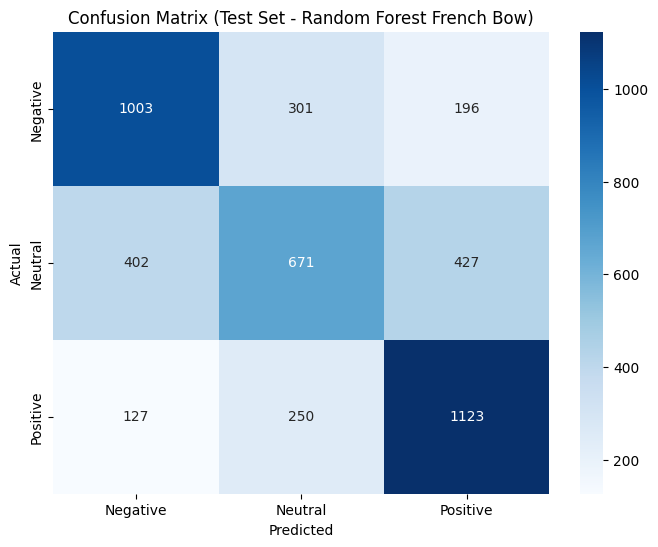

In [ ]:
# Step 1: Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Step 2: Initialize the basic CountVectorizer for French reviews
count_vectorizer_fr = CountVectorizer(strip_accents="unicode")

# Step 3: Fit and transform the French training data
X_train_fr_count = count_vectorizer_fr.fit_transform(X_train['processed_review_french'])   # BoW features for French reviews
X_val_fr_count = count_vectorizer_fr.transform(X_val['processed_review_french'])           # BoW features for validation
X_test_fr_count = count_vectorizer_fr.transform(X_test['processed_review_french'])         # BoW features for test set

# Step 4: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 5: Train the Random Forest model with chosen hyperparameters and balanced class weight
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'  # Balance the class weights automatically
)
rf.fit(X_train_fr_count, y_train)

# Step 6: Evaluate on validation set
y_val_pred = rf.predict(X_val_fr_count)

print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 7: Evaluate on test set
y_test_pred = rf.predict(X_test_fr_count)

print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 8: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - Random Forest French Bow)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

6- Model implementation

B- Random Forest With BOW for English Review.

Validation Set Performance:
Accuracy: 0.5947
Precision: 0.5892
Recall: 0.5947
F1 Score: 0.5909
Test Set Performance:
Accuracy: 0.5853
Precision: 0.5804
Recall: 0.5853
F1 Score: 0.5822


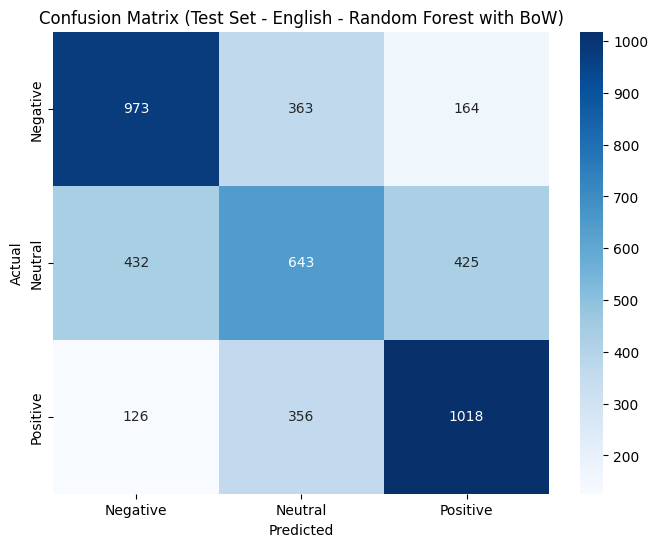

In [ ]:
# Step 1: Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer

# Step 2: Initialize the CountVectorizer for English reviews
count_vectorizer_en = CountVectorizer(strip_accents="unicode")

# Step 3: Fit and transform the English training data using BoW
X_train_en_bow = count_vectorizer_en.fit_transform(X_train['processed_review_english'])   # BoW features for English reviews
X_val_en_bow = count_vectorizer_en.transform(X_val['processed_review_english'])           # BoW features for validation
X_test_en_bow = count_vectorizer_en.transform(X_test['processed_review_english'])         # BoW features for test set

# Step 4: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 5: Train the Random Forest model with chosen hyperparameters and balanced class weight
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'  # Balance the class weights automatically
)
rf.fit(X_train_en_bow, y_train)  # Use BoW features for training

# Step 6: Evaluate on validation set
y_val_pred = rf.predict(X_val_en_bow)

print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 7: Evaluate on test set
y_test_pred = rf.predict(X_test_en_bow)

print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 8: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - English - Random Forest with BoW)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


C- Random Forest With BOW for French Review.

Validation Set Performance:
Accuracy: 0.6218
Precision: 0.6170
Recall: 0.6218
F1 Score: 0.6184
Test Set Performance:
Accuracy: 0.6118
Precision: 0.6072
Recall: 0.6118
F1 Score: 0.6087


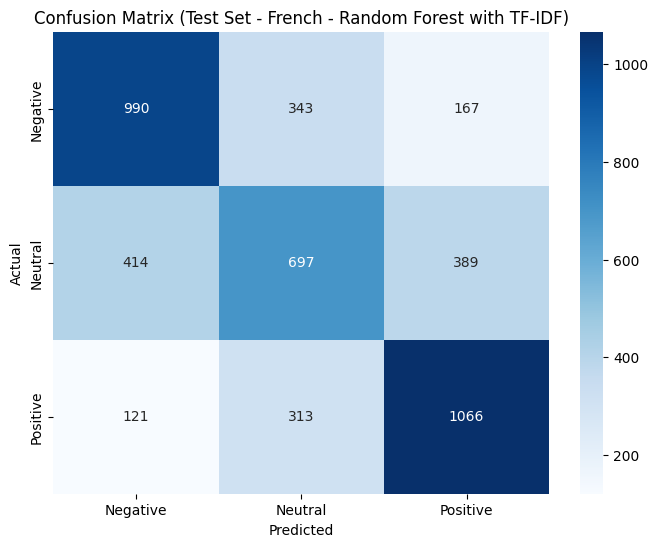

In [ ]:
# Step 1: Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer

# Step 2: Initialize the TF-IDF Vectorizer for French reviews
tfidf_vectorizer_fr = TfidfVectorizer(strip_accents="unicode")

# Step 3: Fit and transform the French training data using TF-IDF
X_train_fr_tfidf = tfidf_vectorizer_fr.fit_transform(X_train['processed_review_french'])   # TF-IDF features for French reviews
X_val_fr_tfidf = tfidf_vectorizer_fr.transform(X_val['processed_review_french'])           # TF-IDF features for validation
X_test_fr_tfidf = tfidf_vectorizer_fr.transform(X_test['processed_review_french'])         # TF-IDF features for test set

# Step 4: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 5: Train the Random Forest model with chosen hyperparameters and balanced class weight
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'  # Balance the class weights automatically
)
rf.fit(X_train_fr_tfidf, y_train)  # Use TF-IDF features for training

# Step 6: Evaluate on validation set
y_val_pred = rf.predict(X_val_fr_tfidf)

print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 7: Evaluate on test set
y_test_pred = rf.predict(X_test_fr_tfidf)

print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 8: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - French - Random Forest with TF-IDF)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

D- Random Forest With TF-IDF for English Review.

Validation Set Performance:
Accuracy: 0.5982
Precision: 0.5931
Recall: 0.5982
F1 Score: 0.5949
Test Set Performance:
Accuracy: 0.5858
Precision: 0.5816
Recall: 0.5858
F1 Score: 0.5833


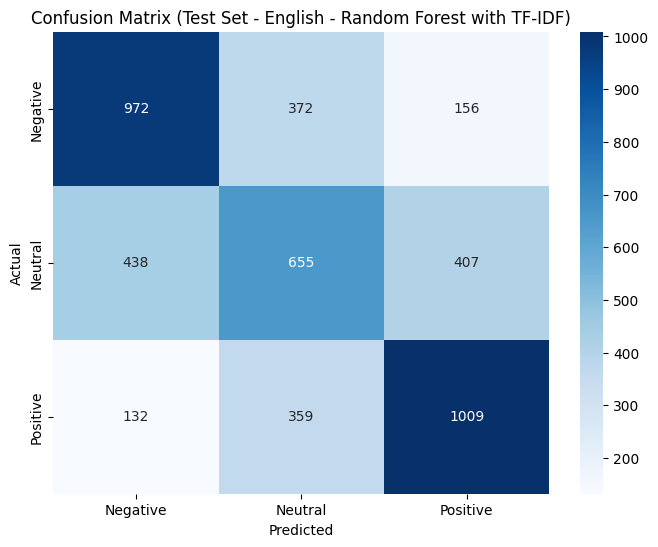

In [ ]:
# Step 1: Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer

# Step 2: Initialize the TF-IDF Vectorizer for English reviews
tfidf_vectorizer_en = TfidfVectorizer(strip_accents="unicode")

# Step 3: Fit and transform the English training data using TF-IDF
X_train_en_tfidf = tfidf_vectorizer_en.fit_transform(X_train['processed_review_english'])   # TF-IDF features for English reviews
X_val_en_tfidf = tfidf_vectorizer_en.transform(X_val['processed_review_english'])           # TF-IDF features for validation
X_test_en_tfidf = tfidf_vectorizer_en.transform(X_test['processed_review_english'])         # TF-IDF features for test set

# Step 4: Extract y values
y_train = train_df['rating_binary']
y_val = val_df['rating_binary']
y_test = test_df['rating_binary']

# Step 5: Train the Random Forest model with chosen hyperparameters and balanced class weight
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'  # Balance the class weights automatically
)
rf.fit(X_train_en_tfidf, y_train)  # Use TF-IDF features for training

# Step 6: Evaluate on validation set
y_val_pred = rf.predict(X_val_en_tfidf)

print("Validation Set Performance:")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 7: Evaluate on test set
y_test_pred = rf.predict(X_test_en_tfidf)

print("Test Set Performance:")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 8: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - English - Random Forest with TF-IDF)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


E- Random Forest With Word2vec For English

In [ ]:
pip install gensim

Validation Set Performance (Word2Vec - English - RF):
Accuracy: 0.5327
Precision: 0.5306
Recall: 0.5327
F1 Score: 0.5314

Test Set Performance (Word2Vec - English - RF):
Accuracy: 0.5373
Precision: 0.5366
Recall: 0.5373
F1 Score: 0.5369


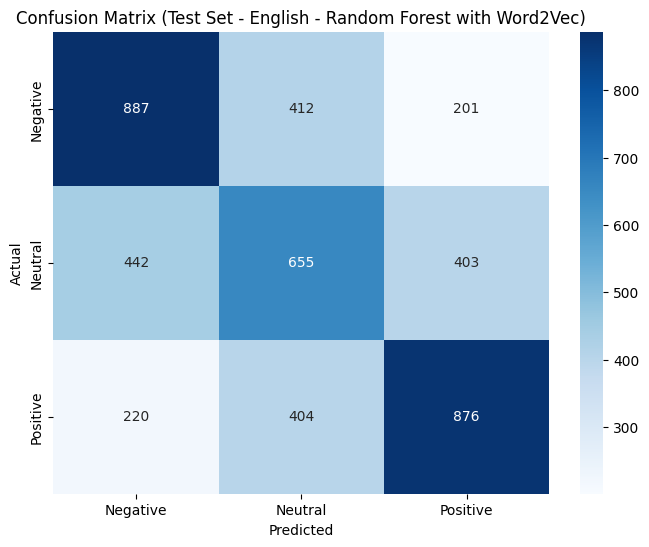

In [ ]:
# Step 1: Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from gensim.models import Word2Vec  # Import Word2Vec

# Step 2: Prepare your preprocessed English data using Word2Vec
# Create Word2Vec model
sentences = [text.split() for text in X_train['processed_review_english']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Function to get average Word2Vec embeddings for a document
def get_w2v_embeddings(text, model):
    words = text.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Get embeddings for train, validation, and test sets
en_X_train_w2v = np.array([get_w2v_embeddings(text, w2v_model) for text in X_train['processed_review_english']])
en_X_val_w2v = np.array([get_w2v_embeddings(text, w2v_model) for text in X_val['processed_review_english']])
en_X_test_w2v = np.array([get_w2v_embeddings(text, w2v_model) for text in X_test['processed_review_english']])

# Step 3: Train the Random Forest model
rf_en_w2v = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)
rf_en_w2v.fit(en_X_train_w2v, y_train)


# Step 4: Evaluate on validation set
y_val_pred_en_w2v = rf_en_w2v.predict(en_X_val_w2v)

print("Validation Set Performance (Word2Vec - English - RF):")
val_accuracy = accuracy_score(y_val, y_val_pred_en_w2v)
val_precision = precision_score(y_val, y_val_pred_en_w2v, average='weighted')
val_recall = recall_score(y_val, y_val_pred_en_w2v, average='weighted')
val_f1 = f1_score(y_val, y_val_pred_en_w2v, average='weighted')

print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Step 5: Evaluate on test set
y_test_pred_en_w2v = rf_en_w2v.predict(en_X_test_w2v)

print("\nTest Set Performance (Word2Vec - English - RF):")
test_accuracy = accuracy_score(y_test, y_test_pred_en_w2v)
test_precision = precision_score(y_test, y_test_pred_en_w2v, average='weighted')
test_recall = recall_score(y_test, y_test_pred_en_w2v, average='weighted')
test_f1 = f1_score(y_test, y_test_pred_en_w2v, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Step 6: Plot confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred_en_w2v)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - English - Random Forest with Word2Vec)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Validation Set Performance (Word2Vec - French - RF):
Accuracy: 0.5631
Precision: 0.5641
Recall: 0.5631
F1 Score: 0.5635

Test Set Performance (Word2Vec - French - RF):
Accuracy: 0.5573
Precision: 0.5587
Recall: 0.5573
F1 Score: 0.5579


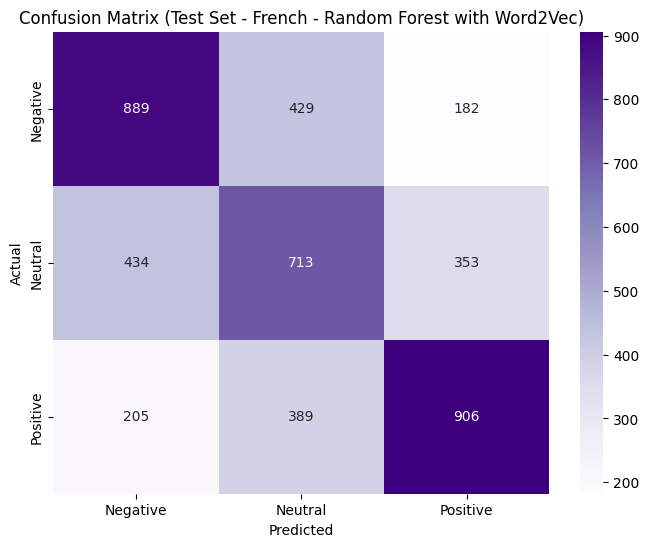

In [ ]:
# Step 1: Prepare data for Word2Vec
sentences_fr = [text.split() for text in X_train['processed_review_french']]

# Train Word2Vec model on French training sentences
w2v_model_fr = Word2Vec(sentences_fr, vector_size=100, window=5, min_count=5, workers=4)

# Helper function: average embeddings
def get_w2v_embeddings(text, model):
    words = text.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Step 2: Get Word2Vec embeddings
fr_X_train_w2v = np.array([get_w2v_embeddings(text, w2v_model_fr) for text in X_train['processed_review_french']])
fr_X_val_w2v = np.array([get_w2v_embeddings(text, w2v_model_fr) for text in X_val['processed_review_french']])
fr_X_test_w2v = np.array([get_w2v_embeddings(text, w2v_model_fr) for text in X_test['processed_review_french']])

# Step 3: Train Random Forest
rf_fr_w2v = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)
rf_fr_w2v.fit(fr_X_train_w2v, y_train)

# Step 4: Validation Set Evaluation
y_val_pred_fr_w2v = rf_fr_w2v.predict(fr_X_val_w2v)
val_accuracy_fr = accuracy_score(y_val, y_val_pred_fr_w2v)
val_precision_fr = precision_score(y_val, y_val_pred_fr_w2v, average='weighted')
val_recall_fr = recall_score(y_val, y_val_pred_fr_w2v, average='weighted')
val_f1_fr = f1_score(y_val, y_val_pred_fr_w2v, average='weighted')

print("Validation Set Performance (Word2Vec - French - RF):")
print(f"Accuracy: {val_accuracy_fr:.4f}")
print(f"Precision: {val_precision_fr:.4f}")
print(f"Recall: {val_recall_fr:.4f}")
print(f"F1 Score: {val_f1_fr:.4f}")

# Step 5: Test Set Evaluation
y_test_pred_fr_w2v = rf_fr_w2v.predict(fr_X_test_w2v)
test_accuracy_fr = accuracy_score(y_test, y_test_pred_fr_w2v)
test_precision_fr = precision_score(y_test, y_test_pred_fr_w2v, average='weighted')
test_recall_fr = recall_score(y_test, y_test_pred_fr_w2v, average='weighted')
test_f1_fr = f1_score(y_test, y_test_pred_fr_w2v, average='weighted')

print("\nTest Set Performance (Word2Vec - French - RF):")
print(f"Accuracy: {test_accuracy_fr:.4f}")
print(f"Precision: {test_precision_fr:.4f}")
print(f"Recall: {test_recall_fr:.4f}")
print(f"F1 Score: {test_f1_fr:.4f}")

# Step 6: Confusion Matrix
conf_matrix_fr = confusion_matrix(y_test, y_test_pred_fr_w2v)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fr, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (Test Set - French - Random Forest with Word2Vec)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
